In [1]:
import numpy as np

all_chroma_vectors = np.load('data/01_all_chroma_vectors.npy')
all_chord_labels = np.load('data/01_all_chord_labels.npy')
all_chroma_vectors.shape, all_chord_labels.shape

((3360513, 24), (3360513,))

#### Bit of analysis

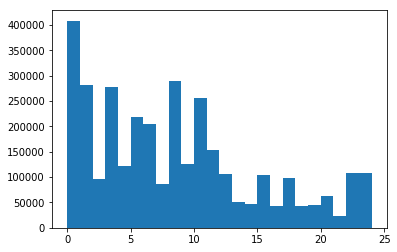

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

counts, _, _ = plt.hist(all_chord_labels, bins=list(set(all_chord_labels)))
plt.show()

In [16]:
min(counts), max(counts)

(22911.0, 408735.0)

Since minimum counts is ~20000, w/c is already a lot, we can get maybe around 1000 from each class as test set, 4000 from each class as validation set on 5 different splits, splits w/o overlapping data points.

#### Splitting

In [2]:
from numpy.random import default_rng

_SEED = 0

# test; must always return same result in successive runs
x = [1,2,3,4,5,6,7,8,9]
rng = default_rng(seed=_SEED)
rng.shuffle(x)

# re-seeding allows to get similar shuffles for diff.arrays
y = [11,22,33,44,55,66,77,88,99]
rng = default_rng(seed=_SEED)
rng.shuffle(y)

z = [0,1,2,3,4,5,6,7,8]
rng = default_rng(seed=_SEED)
rng.shuffle(z)

x, y, z

([5, 6, 3, 7, 4, 9, 8, 1, 2],
 [55, 66, 33, 77, 44, 99, 88, 11, 22],
 [4, 5, 2, 6, 3, 8, 7, 0, 1])

In [4]:
def shuffle_set(array_set):
    """ Shuffle in unison all arrays in array_set """
    for arr in array_set:
        rng = default_rng(seed=_SEED)
        rng.shuffle(arr)
    
    return array_set

x = [1,2,3,4,5,6,7,8,9]
y = [11,22,33,44,55,66,77,88,99]
z = [0,1,2,3,4,5,6,7,8]
x,y,z = shuffle_set((x,y,z))

x,y,z

([5, 6, 3, 7, 4, 9, 8, 1, 2],
 [55, 66, 33, 77, 44, 99, 88, 11, 22],
 [4, 5, 2, 6, 3, 8, 7, 0, 1])

We'll shuffle first before splitting to add some randomness in the data.

In [18]:
import numpy as np

_NUM_TEST_PER_CLASS = 1 #1000
_NUM_VAL_PER_CLASS = 4 #4000
_NUM_VAL_SPLITS = 5

class QueueData():
    def __init__(self, dataset):
        self.dataset = dataset
        self.st_ix = 0
    
    def take(self, num):
        st, ed = self.st_ix, self.st_ix+num
        queue_out = tuple(data[st:ed] for data in self.dataset)
        self.st_ix = ed
        return queue_out
    
    def flush(self):
        st, ed = self.st_ix, len(dataset[0])
        queue_out = tuple(data[st:ed] for data in self.dataset)
        return queue_out

class SplitData():
    def __init__(self):
        self.feats = None
        self.labels = None
        
    def push(self, feats, labels):
        if self.feats is None:
            self.feats = feats
        else:
            self.feats = np.concatenate((self.feats, feats))
        
        if self.labels is None:
            self.labels = labels
        else:
            self.labels = np.concatenate((self.labels, labels))

def get_splits(feats, labels):
    """ Return training, validation, and test sets """
    classes = list(set(labels))
    classes.sort()
    
    test_split = SplitData()
    val_splits = [SplitData() for i in range(_NUM_VAL_SPLITS)]
    train_split = SplitData()
    
    for cls in classes:
        mask = (labels==cls)
        queue = QueueData(dataset=(feats[mask], labels[mask]))
        
        test_split.push(*queue.take(_NUM_TEST_PER_CLASS))
#         for ix in range(_NUM_VAL_SPLITS):
#             queue.take(_NUM_VAL_PER_CLASS)

    return test_split

test_split = get_splits(all_chroma_vectors[:100], all_chord_labels[:100])

In [22]:
test_split.feats.shape, test_split.labels.shape

((2, 24), (2,))

TO DO: Encapsulate whole "Simple dataset" functionality in a class

In [2]:
import tensorflow as tf

base_dataset = tf.data.Dataset.from_tensor_slices((all_chroma_vectors, all_chord_labels))

In [18]:
base_dataset

<TensorSliceDataset shapes: ((24,), ()), types: (tf.float64, tf.int64)>

In [3]:
help(base_dataset)

Help on TensorSliceDataset in module tensorflow.python.data.ops.dataset_ops object:

class TensorSliceDataset(DatasetSource)
 |  A `Dataset` of slices from a dataset element.
 |  
 |  Method resolution order:
 |      TensorSliceDataset
 |      DatasetSource
 |      DatasetV2
 |      collections.abc.Iterable
 |      tensorflow.python.training.tracking.base.Trackable
 |      tensorflow.python.framework.composite_tensor.CompositeTensor
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, element)
 |      See `Dataset.from_tensor_slices()` for details.
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  element_spec
 |      The type specification of an element of this dataset.
 |      
 |      >>> dataset = tf.data.Dataset.from_tensor_slices([1, 2, 3])
 |      >>> dataset.element_spec
 |      TensorSpec(shape=(), dtype=tf.int32, name=None)
 |      
 |      Returns:
 |        A nested structure